# Handwritten Digit Recognition_MNIST_PyTorch by [Mominul Haque](https://github.com/mominulhq)

Importing required library

In [19]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler
import warnings


warnings.filterwarnings('ignore')

np.random.seed(42)


initialize the dataset path

In [20]:
train = pd.read_csv('/content/drive/Shareddrives/Research/Mominul/MNIST/MNIST_train.csv', dtype=np.float32)
test = pd.read_csv('/content/drive/Shareddrives/Research/Mominul/MNIST/MNIST_test.csv', dtype=np.float32)

Preprocess those image of dataset

In [21]:
def preprocessing(train, test, split_train_size=0.2):
    # Split data into features(pixels) and labels(numbers from 0 to 9)
    targets = train.label.values
    features = train.drop(["label"], axis=1).values
    # Normalization
    features = features / 255.
    X_test = test.values / 255.

    X_train, X_val, y_train, y_val = train_test_split(features,
                                                      targets,
                                                      test_size=split_train_size,
                                                      random_state=42)
    X_train = torch.from_numpy(X_train)
    y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # data type is long

    # Create feature and targets tensor for test set.
    X_val = torch.from_numpy(X_val)
    y_val = torch.from_numpy(y_val).type(torch.LongTensor)  # data type is long

    # Create feature tensor for train set.
    X_test = torch.from_numpy(X_test)

    return X_train, y_train, X_val, y_val, X_test


X_train, y_train, X_val, y_val, X_test = preprocessing(train, test)

print(f'Shape of training data: {X_train.shape}')
print(f'Shape training labels: {y_train.shape}')
print(f'Shape of validation data: {X_val.shape}')
print(f'Shape of valiation labels: {y_val.shape}')
print(f'Shape of testing data: {X_test.shape}')

Shape of training data: torch.Size([33600, 784])
Shape training labels: torch.Size([33600])
Shape of validation data: torch.Size([8400, 784])
Shape of valiation labels: torch.Size([8400])
Shape of testing data: torch.Size([28000, 784])


Hyparameter

In [22]:
# batch_size, epoch and iteration
BATCH_SIZE = 100
N_ITER = 2500
EPOCHS = 15

Dataloader for Train & Test Set

In [23]:
# Pytorch train and test sets
train_tensor = torch.utils.data.TensorDataset(X_train, y_train)
val_tensor = torch.utils.data.TensorDataset(X_val, y_val)
test_tensor = torch.utils.data.TensorDataset(X_test)

# data loader
train_loader = torch.utils.data.DataLoader(train_tensor,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_tensor,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)
test_loader = torch.utils.data.DataLoader(test_tensor,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

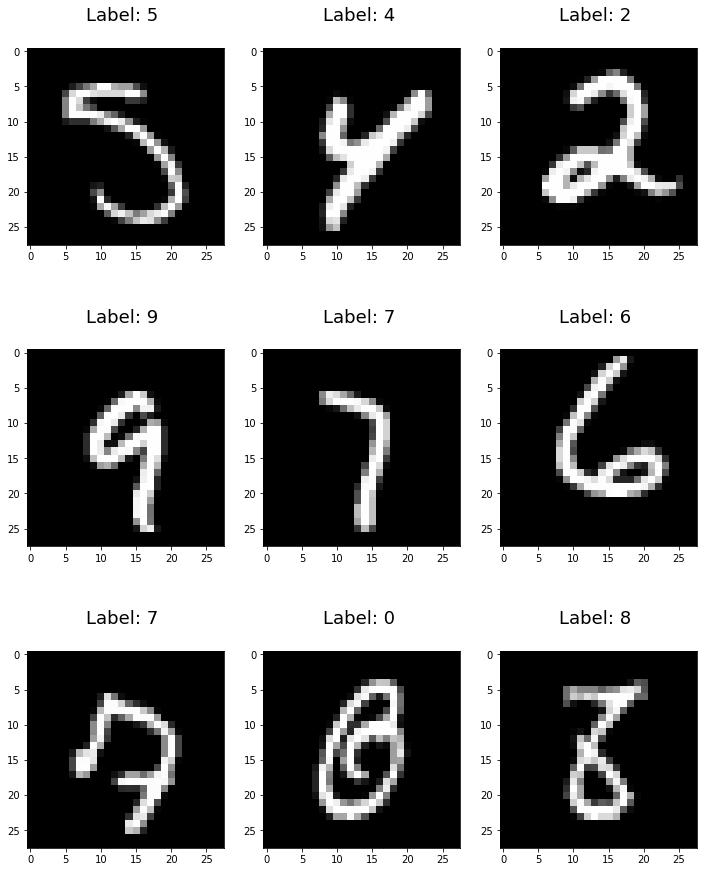

In [24]:
def display_images(graph_indexes=np.arange(9)):
    plt.figure(figsize=(12, 12))
    for graph_index in graph_indexes:
        # Draw randomly an index
        index = random.randint(1, X_train.shape[0])

        # Get corresponding label (.numpy to get value of a tensor)
        label = y_train[index].numpy()

        # define subplot
        plt.subplot(330 + 1 + graph_index)
        plt.title('Label: %s \n' % label,
                  fontsize=18)
        # plot raw pixel data (1d tensor that needs to be resized)
        plt.imshow(X_train[index].resize(28, 28), cmap=plt.get_cmap('gray'))

    # the bottom of the subplots of the figure
    plt.subplots_adjust(bottom=0.001)
    plt.subplots_adjust(top=0.99)


plt.show()
display_images()


In [25]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # convolution 1
        self.c1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5, 5), stride=[1], padding=0)
        self.relu1 = nn.ReLU()

        # maxpool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))

        # dropout 1
        self.dropout1 = nn.Dropout(0.25)

        # convolution 2
        self.c2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=[1], padding=0)
        self.relu2 = nn.ReLU()

        # maxpool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))

        # dropout 2
        self.dropout2 = nn.Dropout(0.25)

        # linear 1
        self.fc1 = nn.Linear(32 * 5 * 5, 256)

        # dropout 3
        self.dropout3 = nn.Dropout(0.25)

        # linear 2
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        out = self.c1(x)  # [BATCH_SIZE, 16, 24, 24]
        out = self.relu1(out)
        out = self.maxpool1(out)  # [BATCH_SIZE, 16, 12, 12]
        out = self.dropout1(out)

        out = self.c2(out)  # [BATCH_SIZE, 32, 10, 10]
        out = self.relu2(out)
        out = self.maxpool2(out)  # [BATCH_SIZE, 32, 5, 5]
        out = self.dropout2(out)

        out = out.view(out.size(0), -1)  # [BATCH_SIZE, 32*5*5=800]
        out = self.fc1(out)  # [BATCH_SIZE, 256]
        out = self.dropout3(out)
        out = self.fc2(out)  # [BATCH_SIZE, 10]

        return out

# Create CNN
model = CNNModel()


In [26]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# LR scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# On GPU if possible
if torch.cuda.is_available():
    print("Model will be training on GPU")
    model = model.cuda()
    criterion = criterion.cuda()
else:
    print("Model will be training on CPU")

Model will be training on CPU


Epoch 1 of 15

Training...
Train Epoch: 1 [5000/33600 (15%)]	Loss: 0.227376
Train Epoch: 1 [10000/33600 (30%)]	Loss: 0.162559
Train Epoch: 1 [15000/33600 (45%)]	Loss: 0.100108
Train Epoch: 1 [20000/33600 (60%)]	Loss: 0.232231
Train Epoch: 1 [25000/33600 (74%)]	Loss: 0.109478
Train Epoch: 1 [30000/33600 (89%)]	Loss: 0.070538
Validating...
Train Loss: 0.0025, Train Acc: 92.23
Val Loss: 0.0007, Val Acc: 97.79

Epoch 2 of 15

Training...
Train Epoch: 2 [5000/33600 (15%)]	Loss: 0.073994
Train Epoch: 2 [10000/33600 (30%)]	Loss: 0.084790
Train Epoch: 2 [15000/33600 (45%)]	Loss: 0.058691
Train Epoch: 2 [20000/33600 (60%)]	Loss: 0.059508
Train Epoch: 2 [25000/33600 (74%)]	Loss: 0.096723
Train Epoch: 2 [30000/33600 (89%)]	Loss: 0.074062
Validating...
Train Loss: 0.0010, Train Acc: 96.93
Val Loss: 0.0007, Val Acc: 97.79

Epoch 3 of 15

Training...
Train Epoch: 3 [5000/33600 (15%)]	Loss: 0.071631
Train Epoch: 3 [10000/33600 (30%)]	Loss: 0.042385
Train Epoch: 3 [15000/33600 (45%)]	Loss: 0.065438
Tr

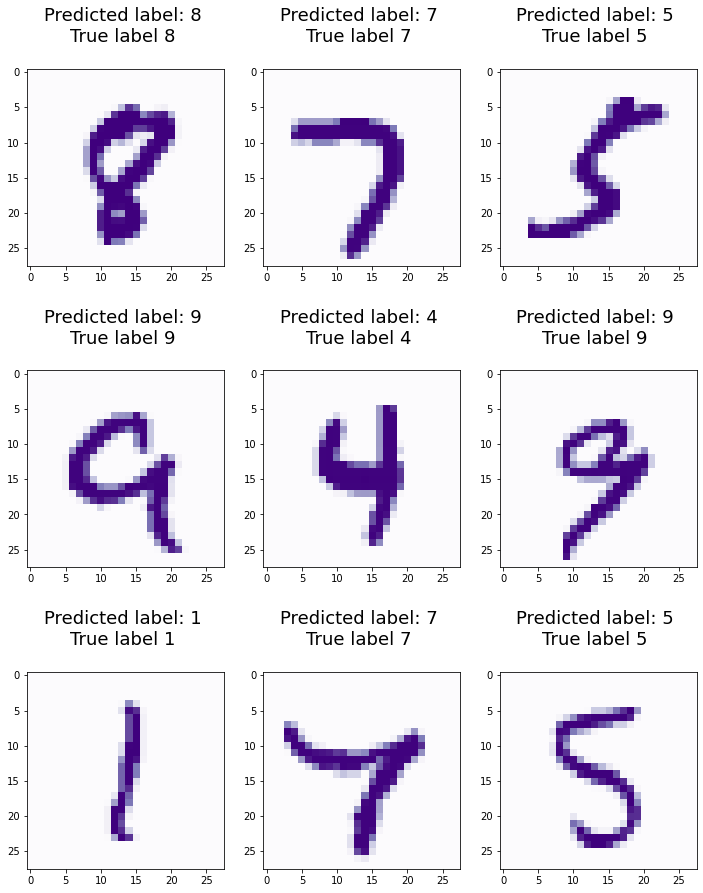

None


In [27]:

def fit(epoch):
    print("Training...")
    # Set model on training mode
    model.train()

    # Update lr parameter
    exp_lr_scheduler.step()

    # Initialize train loss and train accuracy
    train_running_loss = 0.0
    train_running_correct = 0
    train_running_lr = optimizer.param_groups[0]['lr']

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data.view(BATCH_SIZE, 1, 28, 28)), Variable(target)

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()

        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1,
                (batch_idx + 1) * len(data),
                len(train_loader.dataset),
                BATCH_SIZE * (batch_idx + 1) / len(train_loader),
                loss.cpu().detach().numpy())
            )

    train_loss = train_running_loss / len(train_loader.dataset)
    train_accuracy = 100. * train_running_correct / len(train_loader.dataset)

    return train_loss, train_accuracy, train_running_lr


def validate(data_loader):
    print("Validating...")
    # Set model on validating mode
    model.eval()
    val_preds = torch.LongTensor()
    val_proba = torch.LongTensor()

    # Initialize validation loss and validation accuracy
    val_running_loss = 0.0
    val_running_correct = 0

    for data, target in data_loader:
        # Regarding volatile argument, check the note below
        data, target = Variable(data.view(BATCH_SIZE, 1, 28, 28), volatile=True), Variable(target)

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        output = model(data)
        loss = criterion(output, target)

        val_running_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1]
        proba = torch.nn.functional.softmax(output.data)

        val_running_correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        # Store val_predictions with probas for confusion matrix calculations & best errors made
        val_preds = torch.cat((val_preds, pred))
        val_proba = torch.cat((val_proba, proba))

    val_loss = val_running_loss / len(data_loader.dataset)
    val_accuracy = 100. * val_running_correct / len(data_loader.dataset)

    return val_loss, val_accuracy, val_preds, val_proba


train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
val_preds, val_proba = [], []
train_lr = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} of {EPOCHS}\n")

    train_epoch_loss, train_epoch_accuracy, train_epoch_lr = fit(epoch)
    val_epoch_loss, val_epoch_accuracy, val_epoch_preds, val_epoch_proba = validate(val_loader)

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_lr.append(train_epoch_lr)

    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_preds.append(val_epoch_preds)
    val_proba.append(val_epoch_proba)

    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}\n')

torch.save({'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion, },
           './model.pth')

# load the model checkpoint
checkpoint = torch.load('./model.pth')

print(f"Trained for {EPOCHS} number of epochs...")

y_pred_classes = val_preds[EPOCHS - 1].cpu().numpy().ravel()


def display_predicted_images(graph_indexes=np.arange(9)):
    # plot first few images
    plt.figure(figsize=(12, 12))

    for graph_index in graph_indexes:
        index = random.randint(1, X_val.shape[0])

        # Get corresponding label
        predicted_label = y_pred_classes[index]
        true_label = y_val[index]

        # define subplot
        plt.subplot(330 + 1 + graph_index)
        plt.title('Predicted label: %s \n' % predicted_label + \
                  'True label %s \n' % true_label.item(),
                  fontsize=18)
        # plot raw pixel data
        plt.imshow(X_val[index].view(28, 28), cmap=plt.get_cmap('Purples'))
    plt.subplots_adjust(bottom=0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top=0.99)

    # show the figure
    plt.show()
print(display_predicted_images())